In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(70, 274, 3)


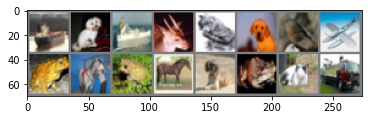

 ship   dog  ship  deer
torch.Size([3, 32, 32])


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

In [5]:
class Inception(nn.Module):
    def __init__(self, in_planes,
                   n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )
        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
            out = self.pre_layers(x)
            out = self.a3(out)
            out = self.b3(out)
            out = self.maxpool(out)
            out = self.a4(out)
            out = self.b4(out)
            out = self.c4(out)
            out = self.d4(out)
            out = self.e4(out)
            out = self.maxpool(out)
            out = self.a5(out)
            out = self.b5(out)
            out = self.avgpool(out)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
            return out
net = Net()


In [7]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [8]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
num_epoch = 30
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.85)
#lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(num_epoch * 0.5), int(num_epoch * 0.75)], gamma=0.1, last_epoch=-1)


In [9]:
# Function to train the network
loss_values = []
def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):
    
    for epoch in range(max_epoch):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:   
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
        loss_values.append(running_loss)

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [10]:
PATH = './cifar_net.pth'
train(net, trainloader, num_epoch, criterion, optimizer, PATH)

[1,  1000] loss: 1.534
[1,  2000] loss: 2.658
[1,  3000] loss: 3.590
[2,  1000] loss: 0.746
[2,  2000] loss: 1.429
[2,  3000] loss: 2.071
[3,  1000] loss: 0.520
[3,  2000] loss: 1.038
[3,  3000] loss: 1.517
[4,  1000] loss: 0.386
[4,  2000] loss: 0.784
[4,  3000] loss: 1.173
[5,  1000] loss: 0.286
[5,  2000] loss: 0.595
[5,  3000] loss: 0.923
[6,  1000] loss: 0.226
[6,  2000] loss: 0.474
[6,  3000] loss: 0.728
[7,  1000] loss: 0.182
[7,  2000] loss: 0.379
[7,  3000] loss: 0.590
[8,  1000] loss: 0.128
[8,  2000] loss: 0.285
[8,  3000] loss: 0.459
[9,  1000] loss: 0.104
[9,  2000] loss: 0.235
[9,  3000] loss: 0.374
[10,  1000] loss: 0.089
[10,  2000] loss: 0.188
[10,  3000] loss: 0.315
[11,  1000] loss: 0.069
[11,  2000] loss: 0.155
[11,  3000] loss: 0.250
[12,  1000] loss: 0.061
[12,  2000] loss: 0.129
[12,  3000] loss: 0.193
[13,  1000] loss: 0.050
[13,  2000] loss: 0.103
[13,  3000] loss: 0.165
[14,  1000] loss: 0.039
[14,  2000] loss: 0.087
[14,  3000] loss: 0.147
[15,  1000] loss: 0

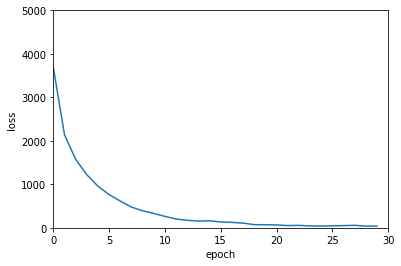

In [11]:
plt.plot(loss_values)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0, 30 , 0, 5000])
plt.show()

In [12]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [13]:
print_accuracy(net, testloader)


Accuracy of the network on the 10000 test images: 88 %
